In [1]:
from matplotlib import pyplot as plt
from torchvision import datasets
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define Settings and Datasets

In [2]:
device = 'cuda:0'
dataset_name = 'CIFAR10'
data_root = './data'

target_classes = ['frog', 'horse']

EPOCHS = 25

In [3]:
class CIFAR10Idx(datasets.CIFAR10):
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(CIFAR10Idx, self).__getitem__(index)
        return (np.array(original_tuple[0]), original_tuple[1], index) 

In [4]:
trainset = CIFAR10Idx(root='./data', train=True, download=True)

idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}
print(idx_to_class)

class_labels = pd.Series(trainset.targets).map(idx_to_class)
interested_idx = np.where(class_labels.isin(target_classes))[0]
subset_labels = class_labels.loc[interested_idx]

label_map = {trainset.class_to_idx[cls]: ix for ix, cls in enumerate(target_classes)}
target_transform = lambda x: label_map[x]
print(label_map)

train_idx, val_idx = train_test_split(interested_idx, test_size=0.1, stratify=subset_labels)

Files already downloaded and verified
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
{6: 0, 7: 1}


In [5]:
np.save('train_zf_index.npy', train_idx)
np.save('val_zf_index.npy', val_idx)

In [6]:
# compose chains image transformations together to form an image preprocessing pipeline
# ToTensor converts a PIL or numpy array to a pytorch tensor object on [0,1]
# Normalize takes (mean1, mean2...), (std1, std2...), so we have mean 0.5, std 0.5 per channel of the images, which
# are in C H W format
train_xform = transforms.Compose(
    [transforms.RandomAffine(degrees=20, shear=0.1),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_xform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR10Idx(root=data_root, train=True, transform=train_xform, target_transform=target_transform)
val_dataset = CIFAR10Idx(root=data_root, train=True, transform=val_xform, target_transform=target_transform)

trainloader = DataLoader(train_dataset, batch_size=256, sampler=SubsetRandomSampler(train_idx), pin_memory=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=256, sampler=SubsetRandomSampler(val_idx), pin_memory=True, num_workers=2)

In [7]:
# de-normalize the image, convert from tensor to numpy, and show

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# create an iterator from the trainloader object, and get a batch

dataiter = iter(trainloader)
images, labels, idx = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images))

# Define ZFNet Variant

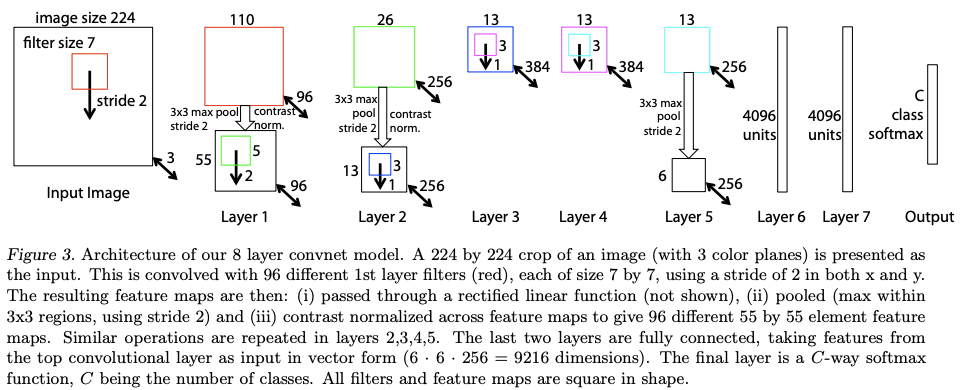

In [35]:
# ZFNet input size is 224x224, but CIFAR is 32x32, so we modify things a bit...

In [22]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 3, stride=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(384 * 4 * 4, 2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.logits = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        
        x = x.view(-1, 384*4*4)
        x = F.relu(self.fc1(x))
        x = self.bn5(x)
        x = F.relu(self.fc2(x))
        x = self.bn6(x)
        x = self.logits(x)
        
        return x


model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (bn5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True

In [23]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train Model

In [24]:
val_loss_hist = []
val_acc_hist = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    print("training...")
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        
        # get the inputs; data is a list of [inputs, labels]
        images, labels, idx = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 50))
            
            running_loss = 0.0
            
            
    print("running evaluation...")
    running_loss = 0
    running_acc = 0

    for i, data in enumerate(valloader):

        # get the inputs; data is a list of [inputs, labels]
        images, labels, idx = data
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)

        accuracy = np.mean(np.equal(np.argmax(outputs.cpu().detach().numpy(), axis=1), labels.cpu().numpy()))

        # print statistics
        running_loss += loss.item()
        running_acc += accuracy
        
    print('[%d, %5d] loss: %.5f acc: %.2f' %
         (epoch + 1, i + 1, running_loss / (i+1), running_acc/(i+1)))
            
    val_loss_hist.append(running_loss)
    val_acc_hist.append(running_acc)
    running_loss = 0.0
    running_acc = 0
    
    torch.save(model.state_dict(), './zf_net_weights/weights' + str(epoch) + '.pth')

training...
[1,     1] loss: 0.01588
running evaluation...
[1,     4] loss: 0.19423 acc: 0.93
training...
[2,     1] loss: 0.00343
running evaluation...
[2,     4] loss: 0.16275 acc: 0.94
training...
[3,     1] loss: 0.00303
running evaluation...
[3,     4] loss: 0.15091 acc: 0.94
training...
[4,     1] loss: 0.00253
running evaluation...
[4,     4] loss: 0.12789 acc: 0.95
training...
[5,     1] loss: 0.00230
running evaluation...
[5,     4] loss: 0.12035 acc: 0.96
training...
[6,     1] loss: 0.00180
running evaluation...
[6,     4] loss: 0.11954 acc: 0.95
training...
[7,     1] loss: 0.00212
running evaluation...
[7,     4] loss: 0.11402 acc: 0.95
training...
[8,     1] loss: 0.00143
running evaluation...
[8,     4] loss: 0.11830 acc: 0.96
training...
[9,     1] loss: 0.00137
running evaluation...
[9,     4] loss: 0.11727 acc: 0.95
training...
[10,     1] loss: 0.00120
running evaluation...
[10,     4] loss: 0.11228 acc: 0.96
training...
[11,     1] loss: 0.00128
running evaluation..

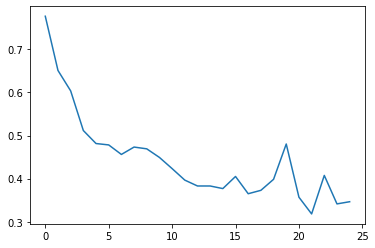

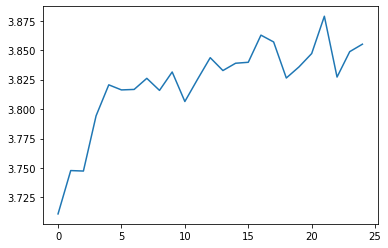

In [25]:
plt.plot(val_loss_hist)
plt.show()
plt.plot(val_acc_hist)
plt.show()

# Load Model

In [26]:
model.load_state_dict(torch.load('./zf_net_weights/weights18.pth'), strict=True)
model.eval()

Net(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (bn5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True

# Measure Conductance

In [27]:
torch.cuda.empty_cache()

from captum.attr import LayerConductance
layers = ['conv1', 'conv2', 'conv3', 'conv4']

lcs = {l: LayerConductance(model, getattr(model, l)) for l in layers}

In [28]:
val_cond_loader = DataLoader(val_dataset, batch_size=1, sampler=SubsetRandomSampler(val_idx), pin_memory=True, num_workers=2)

In [31]:
def getConductance(data_set, save_prefix):

    for layer_ix, (layer_name, lc) in enumerate(lcs.items()):

        attribution_matrix = None
        val_labels = np.zeros((len(val_idx)), dtype='uint8')
        val_image_ids = np.zeros((len(val_idx)), dtype='uint32')
        val_logits = np.zeros((len(val_idx), 2), dtype='float32')

        print(f'### {layer_name}')

        for ix, (images, labels, idx) in enumerate(data_set):
            
            if layer_ix == 0:
                val_logits[ix, :] = model(images.to(device)).squeeze(0).detach().cpu().numpy()
            attribution = lc.attribute(images.to(device), target=labels[0])
            pooled_attribution = F.adaptive_avg_pool2d(attribution, 1).cpu().detach().numpy().squeeze().astype('float16')

            try:
                attribution_matrix[ix, :] = pooled_attribution
            except TypeError:
                attribution_matrix = np.zeros((len(val_idx), len(pooled_attribution)), dtype='float16')
                attribution_matrix[ix, :] = pooled_attribution

            val_labels[ix] = labels.item()
            val_image_ids[ix] = idx

        print(attribution_matrix.shape)
        np.save('./zf_net_conductance/' + save_prefix + '_attrib_' + layer_name + '_.npy', attribution_matrix)
        np.save('./zf_net_conductance/' + save_prefix + '_labels_' + layer_name + '_.npy', val_labels)
        np.save('./zf_net_conductance/' + save_prefix + '_ids_' + layer_name + '_.npy', val_image_ids)
        if layer_ix == 0:
            np.save('./zf_net_conductance/' + save_prefix + '_logits_.npy', val_logits)

In [32]:
getConductance(val_cond_loader, 'val')

### conv1
(1000, 96)
### conv2
(1000, 256)
### conv3
(1000, 384)
### conv4
(1000, 384)


# Construct Test Dataset

In [34]:
testset = CIFAR10Idx(root='./data', train=False, download=True)
test_class_labels = pd.Series(testset.targets).map(idx_to_class)
test_id_idx = np.where(test_class_labels.isin(np.unique(subset_labels)))[0]
test_ood_idx = np.where(~test_class_labels.isin(np.unique(subset_labels)))[0]

test_id_dataset = CIFAR10Idx(root=data_root, train=False, transform=val_xform, target_transform=target_transform)
test_ood_dataset = CIFAR10Idx(root=data_root, train=False, transform=val_xform)

test_id_dl = DataLoader(test_id_dataset, batch_size=1, sampler=SubsetRandomSampler(test_id_idx), pin_memory=True, num_workers=2)
test_ood_dl = DataLoader(test_ood_dataset, batch_size=1, sampler=SubsetRandomSampler(test_ood_idx), pin_memory=True, num_workers=2)

Files already downloaded and verified


In [35]:
import os
import numpy as np
from torch.nn import functional as F

targets = [0, 1]

for loader_name, data_loader, indices in zip(['test-id', 'test-ood'], [test_id_dl, test_ood_dl], [test_id_idx, test_ood_idx]):

    print(f'# {loader_name}')
    for layer_ix, (layer_name, lc) in enumerate(lcs.items()):
        attribution_matrix = None
        test_labels = np.zeros((len(indices)), dtype='uint8')
        test_image_ids = np.zeros((len(indices)), dtype='uint32')
        all_logits = np.zeros((len(indices), 2), dtype='float32')
        print(f'### {layer_name}')

        for im_ix, (images, labels, idx) in enumerate(data_loader):
            
            if layer_ix == 0:
                all_logits[im_ix, :] = model(images.to(device)).squeeze(0).detach().cpu().numpy()
            
            for target in targets:
                attribution = lc.attribute(images.to(device), target=target)
                pooled_attribution = F.adaptive_avg_pool2d(attribution, 1).cpu().detach().numpy().squeeze().astype('float16')
                
                try:
                    attribution_matrix[target, im_ix, :] = pooled_attribution
                except TypeError:
                    attribution_matrix = np.zeros((len(targets), len(indices), len(pooled_attribution)), dtype='float16')
                    attribution_matrix[target, im_ix, :] = pooled_attribution
            
            test_labels[im_ix] = labels.item()
            test_image_ids[im_ix] = idx

        print(attribution_matrix.shape)
        
        np.save(os.path.join('./zf_net_conductance', f'{loader_name}_attrib_{layer_name}.npy'), attribution_matrix)
        np.save(os.path.join('./zf_net_conductance', f'{loader_name}_labels_{layer_name}.npy'), test_labels)
        np.save(os.path.join('./zf_net_conductance', f'{loader_name}_ids_{layer_name}.npy'), test_image_ids)
        if layer_ix == 0:
            np.save(os.path.join('./zf_net_conductance', f'{loader_name}_logits_.npy'), all_logits)

# test-id
### conv1
(2, 2000, 96)
### conv2
(2, 2000, 256)
### conv3
(2, 2000, 384)
### conv4
(2, 2000, 384)
# test-ood
### conv1
(2, 8000, 96)
### conv2
(2, 8000, 256)
### conv3
(2, 8000, 384)
### conv4
(2, 8000, 384)
